## 1.3 Price Dataset Construction for each Symbol
### Importers

In [1]:
if "google.colab" in str(get_ipython()):
  print("***********************************")
  print("Google Colab environment deployment")
  print("***********************************")
  !pip install yfinance
  from google.colab import drive
  drive.mount('/content/gdrive')
  print("Google Colab environment deployment")
  root = "gdrive/MyDrive/"
else: # local or Paperspace Gradient
  root = ""

In [2]:
# General and Particular Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import re
import yfinance as yf
#import nasdaqdatalink
from tqdm.auto import tqdm
#import gc
import time
from datetime import datetime, timedelta
from pandas_datareader import data as pdr

import requests
from bs4 import BeautifulSoup
import json
yf.pdr_override()

In [ ]:
# request page
html = requests.get("https://www.blackrock.com/cl/productos/239726/#tabsAll").content
soup = BeautifulSoup(html)

# find available dates
holdings = soup.find("div", {"id": "holdings"})
dates_div = holdings.find_all("div", "component-date-list")[1]
dates_div.find_all("option")
dates = [option.attrs["value"] for option in dates_div.find_all("option")]

# download constituents for each date
constituents = pd.Series(dtype=object)
for date in dates:
    resp = requests.get(
        f"https://www.blackrock.com/cl/productos/239726/239726/ishares-core-sp-500-etf/1506433277024.ajax?tab=all&fileType=json&asOfDate={date}"
    ).content[3:]
    tickers = json.loads(resp)
    tickers = [(arr[0], arr[1]) for arr in tickers['aaData']]
    date = datetime.strptime(date, "%Y%m%d")
    constituents[date] = tickers

constituents = constituents.iloc[::-1] # reverse into cronlogical order
constituents.head()
constituents.to_pickle("data/pkl/sp500_component_timeseries.pkl")

/tmp/ipykernel_5623/501512729.py:12: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  constituents = pd.Series()


In [ ]:
""" # ICYMI
constituents = pd.read_pickle(root + "data/pkl/sp500_component_timeseries.pkl") """

In [3]:
wiki = pd.read_csv(root + "data/WIKI_PRICES.zip", parse_dates=True)
wiki = dict(tuple(wiki.groupby('ticker')))
for ticker in wiki:
    wiki[ticker].set_index("date", inplace=True)

In [93]:

import time
import re

yfinance_exceptions = ['GAS', 'HAR', 'CSC', 'EMC', 'GME', 'POM', 'PCL', 'COV', 'ETN', 'COL', 'LLL']
nasdaqdl_exceptions = ['IR']

def yfinance_data(ticker, start, end):    
    ticker = fix_ticker(ticker)
    if ticker in yfinance_exceptions: # abnormal quotes from yfinance or bad mixing with nasdaqdl
        return None    
    try:
        #df = pdr.DataReader(ticker, "yahoo", start, end)
        df = pdr.get_data_yahoo(ticker, start, end, progress=False) # Too much failures
    except:
        time.sleep(1)
        try:
            #df = pdr.DataReader(ticker, "yahoo", start, end)
            df = pdr.get_data_yahoo(ticker, start, end, progress=False)
        except:
            return None
    # adjust ohlc using adj close
    adjfactor = df["Close"] / df["Adj Close"]
    df["Open"] /= adjfactor
    df["High"] /= adjfactor
    df["Low"] /= adjfactor
    df["Close"] = df["Adj Close"]
    df["Volume"] *= adjfactor
    df = df.drop(["Adj Close"], axis=1)
    df = df.rename(str.lower, axis='columns')
    df.index.rename('date', inplace=True)
    #df.index = df.index.strftime("%Y-%m-%d")
    return df

def nasdaqdl_data(ticker, start, end):    
    if ticker in nasdaqdl_exceptions: # abnormal quotes from yfinance or bad mixing with nasdaqdl
        return None    
    if ticker in wiki:
        df = wiki[ticker][start:end]
    else:
        ticker = fix_ticker(ticker)
        if ticker in wiki:
            df = wiki[ticker][start:end]
        else:
            return None
    df = df.drop(['open','high','low','close', 'volume','ex-dividend','split_ratio', 'ticker'], axis=1)
    df = df.rename(index=str, columns={"adj_open": "open",
                                       "adj_high": "high",
                                       "adj_low": "low",
                                       "adj_close": "close",
                                       "adj_volume": "volume"})
    return df

def fix_ticker(ticker):
    rename_table = {
        "-": "LPRAX", # BlackRock LifePath Dynamic Retirement Fund
        "8686": "AFL", # AFLAC
        "4XS": "ESRX", # Express Scripts Holding Company 
        "AAZ": "APC", # Anadarko Petroleum Corporation
        "AG4": "AGN", # Allergan plc
        "BFB": "BF-B", # Brown-Forman Corporation
        "BF.B": "BF-B", # Brown-Forman Corporation
        "BF/B": "BF-B", # Brown-Forman Corporation
        "BF_B" : "BF-B", # Brown-Forman Corporation
        "BLD WI": "BLD", # TopBuild Corp.
        "BRKB": "BRK-B", # Berkshire Hathaway Inc.
        "BRK_B": "BRK-B", # Berkshire Hathaway Inc.
        "CC WI": "CC", # The Chemours Company
        "DC7": "DFS", # Discover Financial Services
        "DWDP": "DD", # Discover Financial Services
        "FB": "META",   # Facebook
        "GGQ7": "GOOG", # Alphabet Inc. Class C
        "GEC": "GE", # General Electric
        "HNZ": "KHC", # The Kraft Heinz Company
        "INCO": "INTC", # Intel
        "LOM": "LMT", # Lockheed Martin Corp.
        "LTD": "LB", # L Brands Inc.
        "LTR": "L", # Loews Corporation        
        "MPN": "MPC", # Marathon Petroleum Corp.
        "MYL": "VTRS", # Mylan NV (VIATRIS)
        "MWZ": "MET", # Metlife Inc.
        "MX4A": "CME", # CME Group Inc.
        "NCRA": "NWSA", # News Corporation
        "NTH": "NOC", # Northrop Grumman Crop.
        "PA9": "TRV", # The Travelers Companies, Inc.
        "QCI": "QCOM", # Qualcomm Inc.
        "RN7": "RF", # Regions Financial Corp
        "RTN" : "RTX", # Raytheon
        "SLBA": "SLB", # Schlumberger Limited
        "SYF-W": "SYF", # Synchrony Financial
        "SWG": "SCHW", # The Charles Schwab Corporation 
        "UAC/C": "UAA", # Under Armour Inc Class A
        "UBSFT": "UBSFY", # Ubisoft Entertainment
        "USX1": "X", # United States Steel Corporation
        "UUM": "UNM", # Unum Group
        "VISA": "V", # Visa Inc         
        "VIAC": "VIA", # viacom
        "WLTW": "WTW" # Willis Towers Watson                
    }
    if ticker in rename_table:
        fix = rename_table[ticker]
    else:
        fix = re.sub(r'[^A-Z]+', '', ticker)
    return fix

def yfinance_data_wrapper(ticker, start, end):
    ticker = fix_ticker(ticker)    
    df = yf.download(ticker, start, end)
    if df.empty:
        return None 
    # adjust volume using adj close (adj close takes into account dividend paying effect)
    adjfactor = df["Close"] / df["Adj Close"]    
    df["Close"] = df["Adj Close"]
    df["Volume"] *= adjfactor
    df = df.drop(["Adj Close", "Open", "High", "Low"], axis=1)
    df = df.rename(str.lower, axis='columns')
    df.index.rename('date', inplace=True)
    df.index = df.index.strftime("%Y-%m-%d")
    return df

In [99]:
from tqdm.auto import tqdm
data = {}
skips = set()

constituents = pd.read_pickle(root + "data/pkl/sp500_component_timeseries.pkl")
constituents = constituents["2011-06-01":]
"""
Fast Check for Ticker Price Data Availability
"""    
#subsetting = ["LLL", "AIV", "VIA", "IR", "LUMN"]                
subsetting = ["VIAB"]                
global_excludes = ["CBE", "TIE", "BMC"]   # bad quotes in both sources (or manually downloaded)
# Y! manually downloaded ["AIV", "EQT"]

query = []
dates = []
for i in tqdm(range(0, len(constituents) - 1)):
    start = str(constituents.index[i].date())
    end = str((constituents.index[i + 1].to_pydatetime() - timedelta(days=1)).date())
    tickers_supported = 0    
    for counter, company in enumerate(constituents[i]):        
        if fix_ticker(company[0]) not in subsetting and len(subsetting)!=0:       
            continue        
        if company[0] in global_excludes: # Company with bad behaviour for Quotes in Y! Finance (TBR)
            continue
        if company in skips:
            continue        
        """
        #df = nasdaqdl_data(company[0], start, end)    
        try:
            if df.empty:
            df = yfinance_data(company[0], start, end);                
        except:
            if df is None:
            df = yfinance_data(company[0], start, end);                
        """
        df = yfinance_data(company[0], start, end);                
        if df is None or df.empty:
            df = nasdaqdl_data(company[0], start, end);                
        if df is None or df.empty:
            skips.add(company)
            continue        
        if fix_ticker(company[0]) in data:
            data[fix_ticker(company[0])]  = pd.concat([data[fix_ticker(company[0])],df])
        else:
            data[fix_ticker(company[0])] = df        
        tickers_supported+=1
    print(f"{start}, tickers cached {tickers_supported}")
    if len(skips)!=0:
        print(skips)    
    query.append(tickers_supported)        
    dates.append(start)    

  0%|          | 0/129 [00:00<?, ?it/s]


1 Failed download:
- VIAB: No data found, symbol may be delisted
2011-06-30, tickers cached 1

1 Failed download:
- VIAB: No data found, symbol may be delisted
2011-07-29, tickers cached 1

1 Failed download:
- VIAB: No data found, symbol may be delisted
2011-08-31, tickers cached 1

1 Failed download:
- VIAB: No data found, symbol may be delisted
2011-09-30, tickers cached 1

1 Failed download:
- VIAB: No data found, symbol may be delisted
2011-10-31, tickers cached 1

1 Failed download:
- VIAB: No data found, symbol may be delisted
2011-11-30, tickers cached 1

1 Failed download:
- VIAB: No data found, symbol may be delisted
2011-12-30, tickers cached 1

1 Failed download:
- VIAB: No data found, symbol may be delisted
2012-01-31, tickers cached 1

1 Failed download:
- VIAB: No data found, symbol may be delisted
2012-02-29, tickers cached 1

1 Failed download:
- VIAB: No data found, symbol may be delisted
2012-03-30, tickers cached 1

1 Failed download:
- VIAB: No data found, symbol 

In [7]:
pd.DataFrame({"start": dates, "ntickers": query}).to_csv(root + "data/sp500_components_cached.csv", index=False)
skips_df = pd.DataFrame(skips, columns=["ticker", "company"])
skips_df.sort_values(by="ticker").drop_duplicates(subset="ticker").to_csv("data/skips_alltimes.csv")

In [100]:
for ticker, df in data.items():
    df = df.reset_index().drop_duplicates(subset='date').set_index('date')
    df.to_csv(root + f"data/{fix_ticker(ticker)}.csv")
    data[ticker] = df
tickers = [fix_ticker(ticker) for ticker in data.keys()]
pd.Series(tickers).to_csv(root + "data/tickers_subset2.csv")

In [101]:
""" tickers = pd.read_csv(root + "data/tickers.csv", usecols=[1])
tickers = tickers.loc[:,"0"].tolist() """

### Other Checks

In [31]:
baseline_pfolio = [pd.read_csv(f"data/{ticker}.csv", index_col='date', parse_dates=True)['close'].rename(ticker).pct_change() for ticker in tickers]
baseline_pfolio = pd.concat(baseline_pfolio, axis=1, sort=True)

In [ ]:
#lst = []
for i in tqdm(range(0, len(constituents) - 1)):
    for company in constituents[i]:        
        if company[0]=="TER":            
            last =constituents.index[i]
            corp = company
            #lst.append((*corp, last))
            print(corp, last)
            continue

""" rarunos = pd.DataFrame(lst, columns=["ticker", "company_name", "date_in_ivv"])
rarunos.drop_duplicates(subset="date_in_ivv").to_csv("data/rarunos_outlier_max.csv") """

[*********************100%***********************]  1 of 1 completed


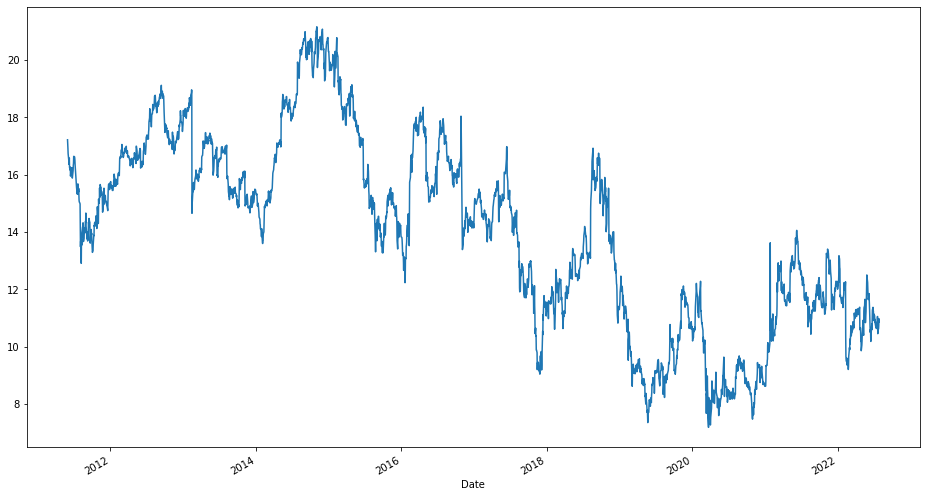

In [92]:
pdr.get_data_yahoo("LUMN", "2011-06-01", "2022-07-29")["Adj Close"].plot(figsize=(16,9));

[*********************100%***********************]  1 of 1 completed


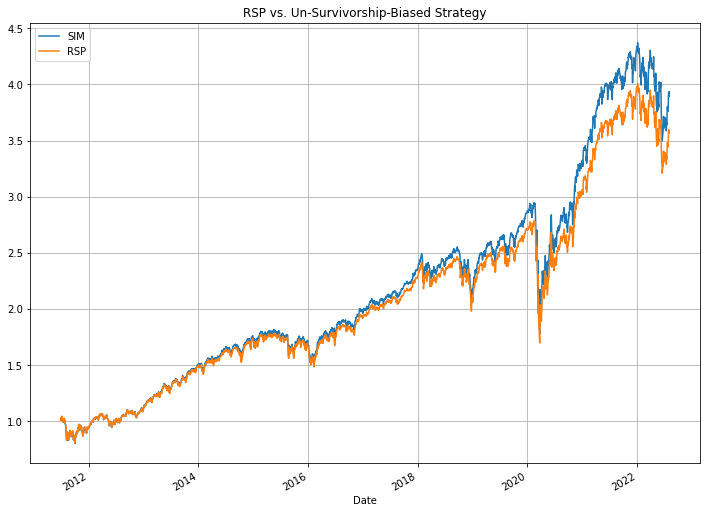

In [240]:
sim_rsp = (
    (pd.concat(
        [pd.read_csv(f"data/{ticker}.csv", index_col='date', parse_dates=True)[
            'close'
        ].pct_change()
        for ticker in tickers],
        axis=1,
        sort=True,
    ).mean(axis=1, skipna=True) + 1)
    .cumprod()
    .rename("SIM")
)

rsp = (
    (pdr.get_data_yahoo("RSP", sim_rsp.index[0], sim_rsp.index[-1])[
        "Adj Close"
    ].pct_change() + 0.002 / 252 + 1)  # 0.20% annual ER
    .cumprod()
    .rename("RSP")
)

sim_rsp.plot(legend=True, title="RSP vs. Un-Survivorship-Biased Strategy", figsize=(12, 9))
rsp.plot(legend=True)
plt.grid();

In [111]:
pictionary = {ticker: pd.read_csv(root + f"data/{ticker}.csv", index_col='date', parse_dates=True)['close'].pct_change() for ticker in tickers}
df = pd.DataFrame(pictionary)

In [221]:
df.head()

,GHC,AZO,CMG,ISRG,SHLDQ,NFLX,GAS,DNB,PCLN,R,...,ESM,WBD,CPT,BALL,ELV,VICI,KDP,ON,VIAB,LLL
date,,,,,,,,,,,,,,,,,,,,,
2011-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-30,0.003594,0.012117,0.012251,0.010071,0.025111,-0.008493,NaN,NaN,NaN,0.033636,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,0.007781,0.009395,0.024433,0.017576,0.009658,0.020176,0.019406,0.008432,0.025136,0.030783,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.017451,0.009834
2011-07-05,-0.006276,-0.001613,0.018149,0.007183,-0.018855,0.080749,0.006024,-0.007525,0.020145,-0.015358,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001156,-0.017439
2011-07-06,-0.005291,0.002053,0.010857,-0.001311,0.003109,0.004592,0.006946,0.006318,0.001420,0.004333,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000192,-0.003573


<AxesSubplot:title={'center':'baseline versus RSP ETF'}, xlabel='date'>

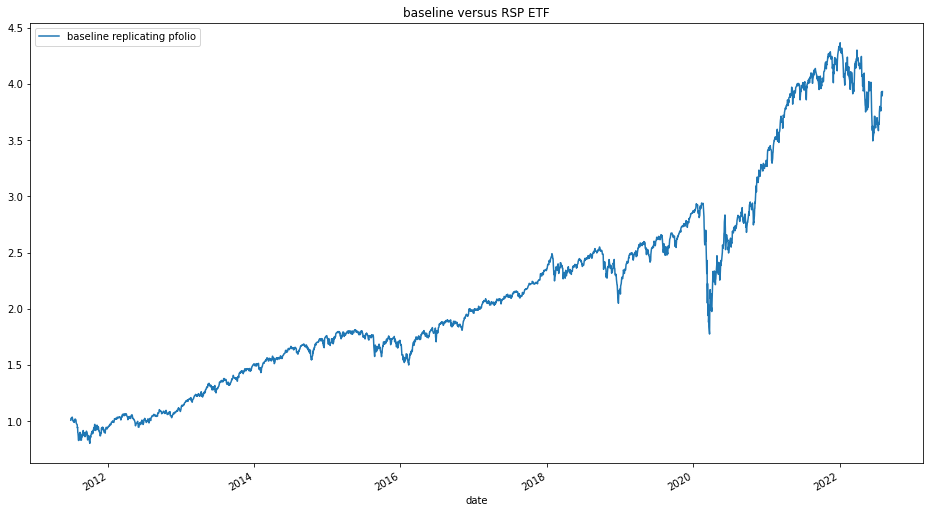

In [239]:
(1+df.mean(axis=1, skipna=True)).cumprod().rename("baseline replicating pfolio").plot(legend=True, title="baseline versus RSP ETF", figsize = (16,9))
#rsp[:"2018-04-01"].plot(legend=True);